# Analysis of Vivino data 🍷
___

In [1]:
# Import required libraries
import sqlite3
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect(r"./db/vivino.db")

# Load CSV data into Pandas DataFrame
# sales_data = pd.read_csv("./db/vivino.db")
# Write the data to a sqlite table
# sales_data.to_sql("vivino", conn, if_exists="replace", index=False)

# Create a cursor object
cur = conn.cursor()

### 1/7 - We want to highlight 10 wines to increase our sales. Which ones should we choose and why?
___


### 2/7 -  We have a limited marketing budget for this year. Which country should we prioritise and why?
___

In the countries table we have different bits of information which could help us forma a decision,
however taking some rations would probably be the best solution. Here we compare:

- the average number of wines per user per country
- the average number of wineries per user per country 

We could interpet these results to say that the higher the ratio, the more likely a user is to encounter 

In [2]:
# Ratio other way around, percentages, cast as float, add where cluase for numerator = 0

query = """
        SELECT
            *,
            CAST(wines_count as float)/users_count*100 AS n_wines_per_100_users,
            CAST(wineries_count as float)/users_count*100 AS n_wineries_per_100_users
        FROM countries
        ORDER BY n_wines_per_100_users desc;
            """
countries_df = pd.read_sql_query(query, conn)
countries_df

,code,name,regions_count,users_count,wines_count,wineries_count,n_wines_per_100_users,n_wineries_per_100_users
0,md,Moldavie,9,13583,5055,418,37.215637,3.077376
1,hu,Hongrie,29,102235,16605,1923,16.241991,1.880961
2,cl,Chili,41,326757,41191,5785,12.606004,1.770429
3,za,Afrique du Sud,112,269649,30857,4227,11.443395,1.567593
4,gr,Grèce,140,95693,9581,1294,10.012227,1.352241
5,hr,Croatie,22,64223,5880,980,9.155598,1.525933
6,au,Australie,120,1022965,90954,13946,8.891213,1.363292
7,fr,France,1306,5973301,422503,67553,7.073191,1.130916
8,de,Allemagne,236,2549989,164533,13643,6.452302,0.535022
9,it,Italie,563,4270717,274658,42399,6.431192,0.992784


In [3]:
query = """
        SELECT
            name AS Country,
            CAST(wines_count as float)/users_count*100 AS n_wines_per_100_users,
            CAST(wineries_count as float)/users_count*100 AS n_wineries_per_100_users
        FROM countries
        ORDER BY n_wines_per_100_users desc;
            """
countries_df = pd.read_sql_query(query, conn)
countries_df

,Country,n_wines_per_100_users,n_wineries_per_100_users
0,Moldavie,37.215637,3.077376
1,Hongrie,16.241991,1.880961
2,Chili,12.606004,1.770429
3,Afrique du Sud,11.443395,1.567593
4,Grèce,10.012227,1.352241
5,Croatie,9.155598,1.525933
6,Australie,8.891213,1.363292
7,France,7.073191,1.130916
8,Allemagne,6.452302,0.535022
9,Italie,6.431192,0.992784


In [4]:
# import seaborn as sns

# sns.lineplot(
#    x="name", y=[["n_wines_per_user", "n_wineries_per_user"]], data=countries_df
# )

### 5/7 - We would like to select wines that are easy to find all over the world. Find the top 3 most common grapes all over the world and for each grape, give us the the 5 best rated wines.
___

First we find the most common grapes in the world. There are two methods which can be used:
1. We assume that the number of wines (wines_cout in most_used_grapes_per_country) is representative of the number of grapes.
2. We count the number of countries that have a specific type of grape


We went with the first option

In [5]:
query = """
        select
            grapes.name as grape_name,
            AVG(most_used_grapes_per_country.wines_count) as wines_count
        from most_used_grapes_per_country
        join grapes on most_used_grapes_per_country.grape_id = grapes.id
        group by grape_name
        order by wines_count desc
        limit 3;
            """
df = pd.read_sql_query(query, conn)
df

,grape_name,wines_count
0,Cabernet Sauvignon,801751.0
1,Chardonnay,604208.0
2,Pinot Noir,572334.0


Now we look at the top 5 wines that have the highest rating per type of grape

In [6]:
query = """
SELECT
    subquery.wine_name,
    subquery.ratings_average,
    subquery.grape_name
FROM
    (
        SELECT
            wines.name AS wine_name,
            wines.ratings_average,
            grapes.name AS grape_name,
            ROW_NUMBER() OVER (PARTITION BY grapes.name ORDER BY wines.ratings_average DESC) AS row_num
        FROM
            countries
            JOIN regions ON countries.code = regions.country_code
            JOIN wines ON regions.id = wines.region_id
            JOIN most_used_grapes_per_country ON countries.code = most_used_grapes_per_country.country_code
            JOIN grapes ON most_used_grapes_per_country.grape_id = grapes.id
        WHERE
            grapes.name IN ('Cabernet Sauvignon', 'Chardonnay', 'Pinot Noir')
    ) AS subquery
WHERE
    subquery.row_num <= 5
ORDER BY
    subquery.grape_name,
    subquery.ratings_average DESC
            """
df = pd.read_sql_query(query, conn)
df

,wine_name,ratings_average,grape_name
0,Cabernet Sauvignon,4.8,Cabernet Sauvignon
1,Mágico,4.8,Cabernet Sauvignon
2,IX Estate Red,4.7,Cabernet Sauvignon
3,Special Selection Cabernet Sauvignon,4.7,Cabernet Sauvignon
4,Unico Reserva Especial Edición,4.7,Cabernet Sauvignon
5,Amarone della Valpolicella Classico Riserva,4.8,Chardonnay
6,Cabernet Sauvignon,4.8,Chardonnay
7,Fratini Bolgheri Superiore,4.8,Chardonnay
8,Cristal Rosé Vinothèque,4.8,Chardonnay
9,Batard-Montrachet Grand Cru,4.8,Chardonnay


Some of these results are not very imformative (ex. row 0), so we attempt to add a winery category

In [7]:
query = """
SELECT
    subquery.wine_name,
    subquery.ratings_average,
    subquery.grape_name,
    subquery.winery_name
FROM
    (
        SELECT
            wines.name AS wine_name,
            wines.ratings_average,
            grapes.name AS grape_name,
            wineries.name AS winery_name,
            ROW_NUMBER() OVER (PARTITION BY grapes.name ORDER BY wines.ratings_average DESC) AS row_num
        FROM
            countries
            JOIN regions ON countries.code = regions.country_code
            JOIN wines ON regions.id = wines.region_id
            JOIN most_used_grapes_per_country ON countries.code = most_used_grapes_per_country.country_code
            JOIN grapes ON most_used_grapes_per_country.grape_id = grapes.id
            JOIN wineries ON wines.winery_id = wineries.id
        WHERE
            grapes.name IN ('Cabernet Sauvignon', 'Chardonnay', 'Pinot Noir')
    ) AS subquery
WHERE
    subquery.row_num <= 5
ORDER BY
    subquery.grape_name,
    subquery.ratings_average DESC
            """
df = pd.read_sql_query(query, conn)
df

,wine_name,ratings_average,grape_name,winery_name
0,The Armagh Shiraz,4.5,Cabernet Sauvignon,Tenuta Tignanello 'Solaia'
1,Lion Tamer Napa Valley Red Blend,4.3,Cabernet Sauvignon,Siepi
2,The Armagh Shiraz,4.5,Chardonnay,Tenuta Tignanello 'Solaia'
3,Raut Lagrein,4.5,Chardonnay,Corte di Cama Sforzato di Valtellina
4,Lion Tamer Napa Valley Red Blend,4.3,Chardonnay,Siepi
5,Lion Tamer Napa Valley Red Blend,4.3,Pinot Noir,Siepi


Unfortunately, this reduces our dataset drastically, and so cannot be used. Even if we were to do an outer join, none of our top 5s have a winery specified, meaning we have to come up with a different solution.

In this case we join the vintages to add more detail, and create a new list, then manually check each wine to see if it matches it's assigned grape. If it does, or if it is a blend and the majority of the blend is of the corresponding grape, then we add it to a new dataframe, until that dataframe is populated with the top 5 wines per grape.

In [8]:
query = """
SELECT
    subquery.vintage_name,
    subquery.ratings_average,
    subquery.grape_name
FROM
    (
        SELECT
            wines.name AS wine_name,
            wines.ratings_average,
            grapes.name AS grape_name,
            vintages.name AS vintage_name,
            ROW_NUMBER() OVER (PARTITION BY grapes.name ORDER BY wines.ratings_average DESC) AS row_num
        FROM
            countries
            JOIN regions ON countries.code = regions.country_code
            JOIN wines ON regions.id = wines.region_id
            JOIN most_used_grapes_per_country ON countries.code = most_used_grapes_per_country.country_code
            JOIN grapes ON most_used_grapes_per_country.grape_id = grapes.id
            JOIN vintages ON wines.id = vintages.wine_id
        WHERE
            grapes.name IN ('Cabernet Sauvignon', 'Chardonnay', 'Pinot Noir')
    ) AS subquery
WHERE
    subquery.row_num <= 20
ORDER BY
    subquery.grape_name,
    subquery.ratings_average DESC
            """
df = pd.read_sql_query(query, conn)
# df.drop(df[df.wine_name == 'Unico'].index, inplace=True)
# df.drop(df[df.wine_name == 'Don PX Convento Selección'].index, inplace=True)
wine_rank_grape_df = df.iloc[
    [0, 2, 3, 13, 15, 23, 24, 26, 35, 36, 41, 46, 53, 57]
].reset_index(drop=True)

# df = df.drop([1,5,8,9,])
# df
wine_rank_grape_df

,vintage_name,ratings_average,grape_name
0,Scarecrow Cabernet Sauvignon 2015,4.8,Cabernet Sauvignon
1,Caymus Special Selection Cabernet Sauvignon 1997,4.7,Cabernet Sauvignon
2,Harlan Estate Harlan Estate Red 1998,4.7,Cabernet Sauvignon
3,Colgin IX Estate Red 2016,4.7,Cabernet Sauvignon
4,Caymus Special Selection Cabernet Sauvignon 2017,4.7,Cabernet Sauvignon
5,Louis Roederer Cristal Rosé Vinothèque 2000,4.8,Chardonnay
6,Pierre Girardin Batard-Montrachet Grand Cru 2020,4.8,Chardonnay
7,Krug Clos du Mesnil 1990,4.7,Chardonnay
8,Krug Clos du Mesnil 1998,4.7,Chardonnay
9,Krug Collection 1995,4.7,Chardonnay


### 6/7 - We would like to create a country leaderboard. Come up with a visual that shows the average wine rating for each country. Do the same for the vintages.
___

In [9]:
query = """
SELECT countries.name AS Country, ROUND(AVG(wines.ratings_average),2) AS average_rating
FROM countries
JOIN regions ON countries.code = regions.country_code
JOIN wines ON regions.id = wines.region_id
GROUP BY Country
ORDER BY average_rating DESC
            """
df = pd.read_sql_query(query, conn)
df

,Country,average_rating
0,Israël,4.50
1,Allemagne,4.50
2,États-Unis,4.49
3,Moldavie,4.48
4,Hongrie,4.47
5,Australie,4.46
6,Afrique du Sud,4.46
7,France,4.45
8,Portugal,4.44
9,Espagne,4.44


In [10]:
query = """
SELECT countries.name AS Country, ROUND(AVG(vintages.ratings_average), 2) AS average_vintage_rating
FROM countries
JOIN regions ON countries.code = regions.country_code
JOIN wines ON regions.id = wines.region_id
JOIN vintages ON wines.id = vintages.wine_id
GROUP BY Country
ORDER BY average_vintage_rating DESC
            """
df = pd.read_sql_query(query, conn)
df

,Country,average_vintage_rating
0,Roumanie,4.50
1,Croatie,4.40
2,Argentine,4.32
3,Chili,4.12
4,Portugal,3.93
5,Moldavie,3.87
6,États-Unis,3.70
7,Afrique du Sud,3.66
8,Italie,3.63
9,Espagne,3.38


### 7/7 - One of our VIP clients likes Cabernet Sauvignon and would like our top 5 recommendations. Which wines would you recommend to him?
___

In [11]:
query = """
SELECT *
FROM (
    SELECT
        vintages.name AS vintage_name,
        vintages.ratings_average,
        vintages.ratings_count,
        keywords_wine.count,
        keywords.name AS keyword_name,
        ROW_NUMBER() OVER (PARTITION BY vintages.name ORDER BY keywords_wine.count DESC) AS row_num
    FROM
        wines
    JOIN
        vintages ON wines.id = vintages.wine_id,
        keywords_wine ON wines.id = keywords_wine.wine_id,
        keywords ON keywords_wine.keyword_id = keywords.id
    WHERE
        keywords_wine.count >= 10
        --vintage_name == 'Château Lafite Rothschild Pauillac (Premier Grand Cru Classé) 2003'
    GROUP BY
        vintage_name,
        keyword_name,
        vintages.ratings_average,
        vintages.ratings_count,
        keywords_wine.count
) AS subquery
WHERE
    --row_num <= 4 AND vintage_name = 'Château Lafite Rothschild Pauillac (Premier Grand Cru Classé) 2003'
    --row_num <= 4 AND vintage_name = 'Scarecrow Cabernet Sauvignon 2015'
    row_num <= 4 AND vintage_name LIKE '%Cabernet Sauvignon%'

ORDER BY
    vintage_name ASC,
    count DESC
            """
df = pd.read_sql_query(query, conn)
df

,vintage_name,ratings_average,ratings_count,count,keyword_name,row_num
0,Beaulieu Vineyard (BV) Georges De Latour Priva...,4.4,465,384,oak,1
1,Beaulieu Vineyard (BV) Georges De Latour Priva...,4.4,465,302,blackberry,2
2,Beaulieu Vineyard (BV) Georges De Latour Priva...,4.4,465,269,vanilla,3
3,Beaulieu Vineyard (BV) Georges De Latour Priva...,4.4,465,231,leather,4
4,Beaulieu Vineyard (BV) Georges De Latour Priva...,4.6,325,384,oak,1
...,...,...,...,...,...,...
135,Stag's Leap Wine Cellars FAY Cabernet Sauvigno...,4.5,451,175,cherry,4
136,Stag's Leap Wine Cellars S.L.V. Cabernet Sauvi...,4.6,231,198,oak,1
137,Stag's Leap Wine Cellars S.L.V. Cabernet Sauvi...,4.6,231,167,blackberry,2
138,Stag's Leap Wine Cellars S.L.V. Cabernet Sauvi...,4.6,231,144,chocolate,3


In [12]:
print(df.value_counts("keyword_name"))

keyword_name
oak             35
blackberry      32
vanilla         19
tobacco         16
leather         14
cherry          11
chocolate        5
cassis           3
plum             2
black cherry     1
blackcurrant     1
dark fruit       1
Name: count, dtype: int64


- Scarecrow Cabernet Sauvignon 2015 - Highest rated Cabernet Sauvignon and was rank 1 in `Vivino's 2019 Wine Style Awards: Napa Valley Cabernet Sauvignon`
- Château Lafite Rothschild Pauillac (Premier Grand Cru Classé) 2003 - Highest rated Cabernet Sauvignon from France. Blend with 86% Cabernet Sauvignon. 1328 euros for 75cl
- 

### New analysis
___

In [93]:
grape_list = [
    "Cabernet Sauvignon",
    "Merlot",
    "Pinot Noir",
    "Chardonnay",
    "Sauvignon Blanc",
    "Syrah",
    "Riesling",
    "Malbec",
    "Zinfandel",
    "Sangiovese",
    "Tempranillo",
    "Grenache",
    "Viognier",
    "Chenin Blanc",
    "Gewürztraminer",
    "Pinot Gris",
    "Pinot Blanc",
    "Albariño",
    "Verdejo",
    "Vermentino",
    "Marsanne",
    "Roussanne",
    "Viura",
    "Garganega",
    "Fiano",
    "Falanghina",
    "Verdicchio",
    "Trebbiano",
    "Carricante",
    "Catarratto",
    "Grillo",
    "Inzolia",
    "Moscato",
    "Muscat",
    "Pedro Ximénez",
]

dictionary = {}


for grape in grape_list:
    query = f"""
    SELECT *
    FROM (
        SELECT
            vintages.name AS vintage_name,
            vintages.ratings_average,
            vintages.ratings_count,
            keywords_wine.count,
            keywords.name AS keyword_name,
            ROW_NUMBER() OVER (PARTITION BY vintages.name ORDER BY keywords_wine.count DESC) AS row_num
        FROM
            wines
        JOIN
            vintages ON wines.id = vintages.wine_id,
            keywords_wine ON wines.id = keywords_wine.wine_id,
            keywords ON keywords_wine.keyword_id = keywords.id
        WHERE
            keywords_wine.count >= 10
            --vintage_name == 'Château Lafite Rothschild Pauillac (Premier Grand Cru Classé) 2003'
        GROUP BY
            vintage_name,
            keyword_name,
            vintages.ratings_average,
            vintages.ratings_count,
            keywords_wine.count
    ) AS subquery
    WHERE
        --row_num <= 4 AND vintage_name = 'Château Lafite Rothschild Pauillac (Premier Grand Cru Classé) 2003'
        --row_num <= 4 AND vintage_name = 'Scarecrow Cabernet Sauvignon 2015'
        row_num <= 4 AND vintage_name LIKE '%{grape}%'

    ORDER BY
        vintage_name ASC,
        count DESC
                """
    df = pd.read_sql_query(query, conn)
    df2 = df.copy()
    df2["grape_name"] = grape
    if len(df2) > 4:
        dictionary[grape] = df2

# print(dictionary)


In [100]:
print(dictionary["Merlot"].head(3))

                       vintage_name  ratings_average  ratings_count  count  \
0  Darioush Merlot (Signature) 2018              4.4            251     84   
1  Darioush Merlot (Signature) 2018              4.4            251     71   
2  Darioush Merlot (Signature) 2018              4.4            251     65   

  keyword_name  row_num grape_name  
0          oak        1     Merlot  
1   blackberry        2     Merlot  
2      vanilla        3     Merlot  


In [ ]:
df_check = []
df_check = dictionary["Cabernet Sauvignon"]
# df_check['grape_name'] = 'Cabernet Sauvignon'
print(df_check)

df_check2 = []
for grape in dictionary:
    df_check2.append(dictionary[grape])

# print(df_check2)


In [57]:
for grape in dictionary:
    print(f"N. of {grape}: {dictionary[grape].vintage_name.nunique()}")
    # print(dictionary[grape].value_counts("keyword_name"))


N. of Cabernet Sauvignon: 35
N. of Merlot: 8
N. of Pinot Noir: 7
N. of Chardonnay: 9
N. of Syrah: 5
N. of Riesling: 13
N. of Malbec: 16


In [68]:
# dictionary['Merlot'].value_counts("keyword_name")
cabernet_df = (
    dictionary["Cabernet Sauvignon"]
    .value_counts("keyword_name")
    .reset_index(name="counts")
    .sort_values(by=["keyword_name"])
)
print(cabernet_df)


    keyword_name  counts
9   black cherry       1
1     blackberry      32
10  blackcurrant       1
7         cassis       3
5         cherry      11
6      chocolate       5
11    dark fruit       1
4        leather      14
0            oak      35
8           plum       2
3        tobacco      16
2        vanilla      19


In [ ]:
keywords_df = pd.DataFrame()
for grape in dictionary:


In [53]:
# Import matplotlib
import matplotlib.pyplot as plt
import numpy as np


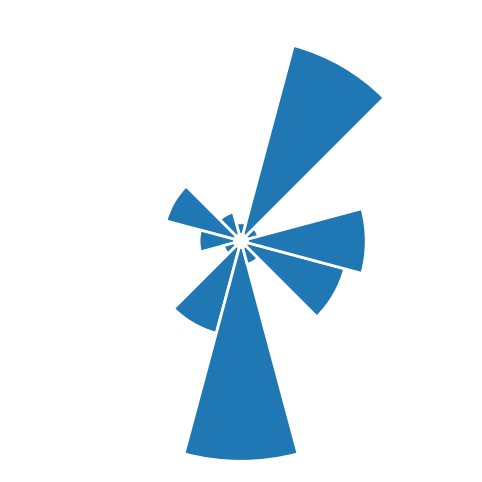

In [78]:
# set figure size
plt.figure(figsize=(10, 6))

# plot polar axis
ax = plt.subplot(111, polar=True)

# remove grid
plt.axis("off")

# Set the coordinates limits
upperLimit = 10
lowerLimit = 1

# Compute max and min in the dataset
max = cabernet_df["counts"].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * cabernet_df.counts + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2 * np.pi / len(cabernet_df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(cabernet_df.index) + 1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles,
    height=heights,
    width=width,
    bottom=lowerLimit,
    linewidth=2,
    edgecolor="white",
)


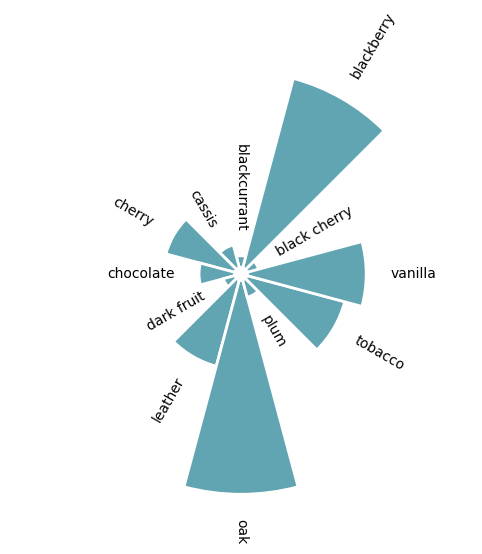

In [77]:
# initialize the figure
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, polar=True)
plt.axis("off")

# Draw bars
bars = ax.bar(
    x=angles,
    height=heights,
    width=width,
    bottom=lowerLimit,
    linewidth=2,
    edgecolor="white",
    color="#61a4b2",
)

# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(
    bars, angles, heights, cabernet_df["keyword_name"]
):
    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi / 2 and angle < 3 * np.pi / 2:
        alignment = "right"
        rotation = rotation + 180
    else:
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle,
        y=lowerLimit + bar.get_height() + labelPadding,
        s=label,
        ha=alignment,
        va="center",
        rotation=rotation,
        rotation_mode="anchor",
    )


In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [80]:
def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else:
        alignment = "left"
    return rotation, alignment


def add_labels(angles, values, labels, offset, ax):
    # This is the space between the end of the bar and the label
    padding = 4

    # Iterate over angles, values, and labels, to add all of them.
    for (
        angle,
        value,
        label,
    ) in zip(angles, values, labels):
        angle = angle

        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle,
            y=value + padding,
            s=label,
            ha=alignment,
            va="center",
            rotation=rotation,
            rotation_mode="anchor",
        )


In [ ]:
ANGLES = np.linspace(0, 2 * np.pi, len(df), endpoint=False)
VALUES = df["value"].values
LABELS = df["name"].values

# Determine the width of each bar.
# The circumference is '2 * pi', so we divide that total width over the number of bars.
WIDTH = 2 * np.pi / len(VALUES)

# Determines where to place the first bar.
# By default, matplotlib starts at 0 (the first bar is horizontal)
# but here we say we want to start at pi/2 (90 deg)
OFFSET = np.pi / 2

# Initialize Figure and Axis
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})

# Specify offset
ax.set_theta_offset(OFFSET)

# Set limits for radial (y) axis. The negative lower bound creates the whole in the middle.
ax.set_ylim(-100, 100)

# Remove all spines
ax.set_frame_on(False)

# Remove grid and tick marks
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Add bars
ax.bar(ANGLES, VALUES, width=WIDTH, linewidth=2, color="#61a4b2", edgecolor="white")

# Add labels
add_labels(ANGLES, VALUES, LABELS, OFFSET, ax)
